<a id='Content'></a>
# Parallel Proof-of-Work

## Submission Contents

+ **CW4 Overview.ipynb** : *programming outline, and blockchain queries*
+ **CW4 Overview.html** : *html export of ipynb*
+ **blockchain_state.py** : *BlockchainState class and verify_reorg function*
+ **blockchain_state_test.py** : *Provided test suite*
+ **keys.py** : *Helper functions for generating, saving, loading private key, and getting address (SHA1 of pk)*
+ **.gitignore** : *To prevent sqlite db of blockchain, venv, and pycache files when using git to transfer to other mining platforms*
+ **connection code files** :
    - **connections.py** : *Update on line 135 to call received_transactions from self.node instead of self*
    - **miner.py** : *Adapted to use multiprocessing mining function from CW3 and adapted search space (see Appendices for details)*
    - **main.py** : *As provided*
    - **mempool.py** : *As provided*
    - **node.py** : *As provided*
    - **persistence.py** : *As provided*
+ **blocks.sqlite** : *Blockchain state before submitting - used in blockchain queries*
+ **zim_miner_sk.pem** : *Secret key used to mine Zimcoin - password encrypted see mining section*
+ **blocks.py** : *program code for UserState and Block classes (adapted from CW3 to use cutoff_time and include get_changes_for_undo)*
+ **transactions.py** : *Transaction class from CW2*
+ **mp_coordinator_state.md** : *markdown file containing mermaid code for state diagram*
+ **mp_coordinator_state.png** : *png explort of mp_coordinator state diagram*
+ **requirements.txt** : *Dependencies*

## Table of Contents

+ [Grading Weights](#Weights)
+ [Program Description](#Program)
    + [Test Suite](#Test)
    + [Blockchain Queries](#blockchain)
***
+ [Appendix A: Notes on Nonces and Oddities](#nonce)
+ [Appendix B: Limitations and Implementation Notes](#implementation)

<a id='Weights'></a>
## Grading Weights
[Back to Top](#Content)

| Program | Essay | Tick one box below |
|----|----|:----:|
| ***100*** | ***0*** | ***X*** |
| 70        | 30      |         |
| 50        | 50      |         |
| 30        | 70      |         |
| 0         | 100     |         |

<a id='Program'></a>
## Program Description
[Back to Top](#Content)

A BlockchainState class and verify_reorg function are defined in blockchain_state.py.

BlockchainState methods:

+ `calculate_difficulty` : *calculates and returns the difficulty of the last block on the longest chain (averaging over the last 10 blocks to get 120 second-level difficulty)*
+ `verify_and_apply_block` : *confirms the following about a block passed as an arg, raising an exception if any are not True:*
    - the block height is less than or equal to the length of the longest chain
    - block.previous is the same as the last block id on the longest chain
    - block.timestamp is greater than or equal to the timestamp of the last block on the chain
    - if the longest chain is empty:
        + block.previous is 32 x 0 bytes (id of a first block)
        + the difficulty is 1000
    - get changes for UserStates
    - append the block to the longest chain
    - update the total difficulty
    - update UserStates
+ `undo_last_block` : *removes the last block from the chain, reduces total difficulty accordingly, gets_changes_for_undo for it and adjusts UserStates accordingly*

Other functions:

+ `verify_reorg`: *makes a copy of the old chain state, calls undo_last_block until it agree with the new state, then verifies and adds new blocks.*

Keys functions:

+ `generate_key` : *generates then returns an elliptic curve secret key using the SECP256K1 curve*
+ `save_key` : *creates a pem file using best available encryption using the env variable ZIM_MINER_PASS or a default as a password*
+ `get_address` : *returns an address (SHA1 of the public key) for a given secret key*
+ `load_key` : *loads a secret key from a provided path to a password protected pem file using the env variable ZIM_MINER_PASS or a default as a password*

<a id='Test'></a>
### Test Suite
[Back to Top](#Content)

In [1]:
import pprint
import sys
import unittest
from collections import Counter
from cryptography.hazmat.backends.openssl.ec import (
    _EllipticCurvePrivateKey,
)  # for typehints
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sqlitedict import SqliteDict
import matplotlib.path as mpath
import matplotlib.patches as patches
from datetime import datetime

import keys
from blockchain_state_test import *

sns.set_theme(style="darkgrid", palette="bright")

print(f"Prepared with Python version: {sys.version}")

Prepared with Python version: 3.8.12 (default, Sep 24 2021, 12:36:12) 
[Clang 13.0.0 (clang-1300.0.29.3)]


In [2]:
unittest.main(argv=[""], verbosity=2, exit=False, failfast=True)

test_difficulty_calculation (blockchain_state_test.BlockchainStateTest) ... ok
test_difficulty_with_zero_time (blockchain_state_test.BlockchainStateTest) ... ok
test_previous_validation (blockchain_state_test.BlockchainStateTest) ... ok
test_reorg (blockchain_state_test.BlockchainStateTest) ... ok
test_undo (blockchain_state_test.BlockchainStateTest) ... ok

----------------------------------------------------------------------
Ran 5 tests in 1.070s

OK


<a id='blockchain'></a>
### Blockchain Queries
[Back to Top](#Content)

We'll load the blockchain (as of from 15-08-2022 at 7:52 AM) into a dataframe and show some blocks mined and transactions conducted.

In [3]:
my_sk: _EllipticCurvePrivateKey = keys.load_key("zim_miner_sk.pem")
my_address: bytes = keys.get_address(my_sk)

# show hex of public address
my_address.hex()

'9b1164c83af4dde8a38898bac79397403864411b'

In [4]:
# some blockchain queries
# load sqlite db into DataFrame
with SqliteDict("blocks.sqlite") as Blockchain:

    bc: pd.DataFrame = pd.DataFrame([v for v in Blockchain.values()])

bc.set_index("height", inplace=True)

my_blocks: pd.DataFrame = bc[bc["miner"] == my_address.hex()]
my_transactions: list = [t for t in bc["transactions"] if my_address.hex() in str(t)]

# get percent and total count of block mined by my address
perc: float = bc["miner"].value_counts(normalize=True).loc[my_address.hex()]
mined: np.int64 = bc["miner"].value_counts().loc[my_address.hex()]

last_timestamp = bc["timestamp"].max()

print("\n".join([f"Blockchain Data From: {last_timestamp} ({datetime.utcfromtimestamp(last_timestamp).strftime('%Y-%m-%d %H:%M:%S')})",
                 f"Total Mined: {mined} ({perc:.02%})",
                 f"Total Transactions: {len(my_transactions)}"]))

Blockchain Data From: 1660549960 (2022-08-15 07:52:40)
Total Mined: 1100 (13.71%)
Total Transactions: 2


In [5]:
# a few block_ids that I've mined...
bc[["block_id", "miner", "difficulty"]][bc["miner"] == my_address.hex()].sort_values(
    "difficulty", ascending=False
)[:15].style.set_caption("Top 15 (of 1100) Blocks Mined by My Address:")

,block_id,miner,difficulty
height,,,
4496,0000000061321499ecfa8351a7e3dd7f8662bac33e3d44935ce7210360ec52a2,9b1164c83af4dde8a38898bac79397403864411b,1806853200
4600,00000002ea425c71d02f22d31eb3f44b2e63ae63976b27519000430b57727fef,9b1164c83af4dde8a38898bac79397403864411b,969287880
4602,00000000a6c7765444271551ef3389aa6adb0984e0c5e1083b2cd381fe2b9dbd,9b1164c83af4dde8a38898bac79397403864411b,892795680
4603,000000008f00d6a9532951b37978d3c52265b721d127950479f191c641c406dd,9b1164c83af4dde8a38898bac79397403864411b,761090640
4274,00000006f51845a95d8382984aafacc1a62d9b048e265547eb1560aeb65a7ce4,9b1164c83af4dde8a38898bac79397403864411b,596612520
3792,000000006200a1b876fa3bd905ea7ca3e051898628c3bc800e5c8cac8dfc1c12,9b1164c83af4dde8a38898bac79397403864411b,491851920
3858,0000000087d0c35f42814bafe2762afd84a2946f65fc2cc9fe5cf972d30161d5,9b1164c83af4dde8a38898bac79397403864411b,456028440
3667,00000007c4a53572f0c8f46b9ed3276c9fd8430b5d700d08b5d2015dbdc6cb2c,9b1164c83af4dde8a38898bac79397403864411b,432918120
3890,000000025015a7496427e9d6e6f2c51869a476611af3a5e0d6ce52fc3008a185,9b1164c83af4dde8a38898bac79397403864411b,430253880


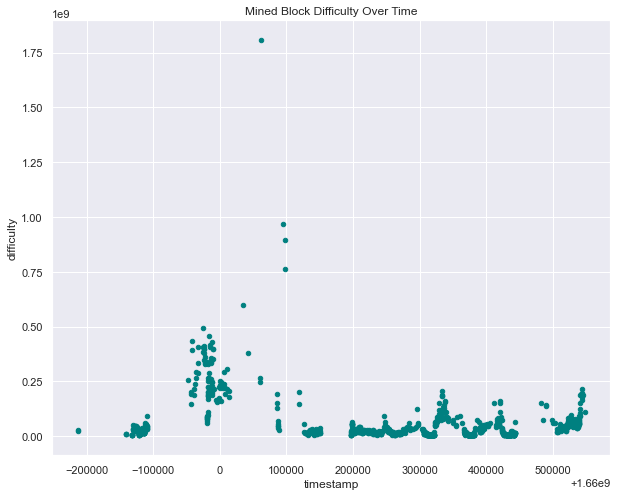

In [6]:
# graph difficulty of mined blocks over time
difficulty_chart = bc[["difficulty", "timestamp"]][
    bc["miner"] == my_address.hex()
].plot.scatter(
    "timestamp",
    "difficulty",
    figsize=(10, 8),
    title="Mined Block Difficulty Over Time",
    color="teal",
)

In [7]:
# a few test transactions were conducted, choosing a miner with only one coin at random and sending them 200 ZC
p: pprint.PrettyPrinter = pprint.PrettyPrinter()
p.pprint(my_transactions)

[[{'amount': 250,
   'fee': 50,
   'nonce': 0,
   'recipient_hash': '8c5077187c173fa6ad8705c0989c7808d5cd2a4a',
   'sender_hash': '9b1164c83af4dde8a38898bac79397403864411b',
   'sender_public_key': '3056301006072a8648ce3d020106052b8104000a034200048a38d030cd4c18580be6adba50de3da5cb99676c3e96c9fc9361d655f3d28a26b3d50861942052601373274a0d0be747c360263cf5cea814f69d239e1278503d',
   'signature': '3045022066ea3a589d9fb33057553acb7c46337c7d5d70a1cc534fbc3850fb617e79be76022100fd0d369a7c77759aea8cd6dc95f427715f3e7cabb3f23e49c2eb5fcfb8d65523',
   'txid': '51c73b83c840570096cdf3761ffedf35f99b05365abb41fc2f4d06a3c0a944dc'}],
 [{'amount': 250,
   'fee': 50,
   'nonce': 1,
   'recipient_hash': '189b1805f47c314da4b316a9e8fd375aa2c746dc',
   'sender_hash': '9b1164c83af4dde8a38898bac79397403864411b',
   'sender_public_key': '3056301006072a8648ce3d020106052b8104000a034200048a38d030cd4c18580be6adba50de3da5cb99676c3e96c9fc9361d655f3d28a26b3d50861942052601373274a0d0be747c360263cf5cea814f69d239e1278503d',
 

***

<a id='nonce'></a>
### Appendix A: Notes on Nonces and Oddities
[Back to Top](#Content)

First, we'll take a look at the nonces of blocks mined by the top 10 miners to visualize some insight about nonce search strategy. We then investigate some unusual results and suggest a possible explanation.

In [8]:
top_10: pd.Index = bc["miner"].value_counts(ascending=False)[:10].index
top_miner: str = top_10[0]
top_10_bc: pd.DataFrame = bc.loc[bc["miner"].isin(top_10)]

top_10

Index(['735c7388347519116daded418c8fe5846b5e5d6d',
       '9b1164c83af4dde8a38898bac79397403864411b',
       '501ace0000000000000000000000000000000000',
       '7a653da2cbffa16a1454ac3e6905edebce38e625',
       'bcf177e59d90d6c647918a0882c672be8b1fe289',
       '761542f895a883b8d06b2d82a98aae4bc4a75906',
       'e54dfce906dee811463e78f00aa10a88972dddea',
       '00b4de12cbe7e8ea746b1fa21bf1c30dfd170e36',
       'd335f2d979d2cc9dfaed8d8c90d50e29aaddcaa2',
       '250289bc31fc6a5ce7846ae2ca99e535350a1ea3'],
      dtype='object')

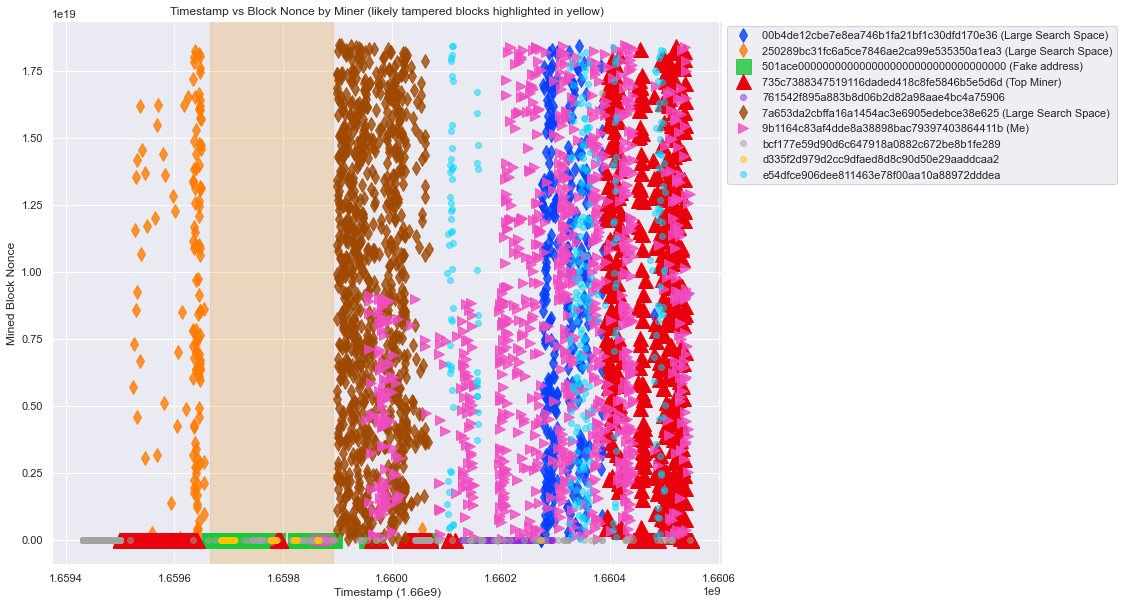

In [9]:
groups: pd.core.groupby.generic.DataFrameGroupBy = top_10_bc.groupby("miner")

fig, ax = plt.subplots(figsize=(12, 10))

for miner, group in groups:
    if miner == top_miner:
        ax.plot(
            group.timestamp,
            group.nonce,
            marker="^",
            markersize=15,
            linestyle="",
            label=f"{miner} (Top Miner)",
        )
    elif miner == my_address.hex():
        ax.plot(
            group.timestamp,
            group.nonce,
            marker=">",
            markersize=10,
            linestyle="",
            label=f"{miner} (Me)",
            alpha=0.8,
        )
    elif miner in [
        "7a653da2cbffa16a1454ac3e6905edebce38e625",
        "250289bc31fc6a5ce7846ae2ca99e535350a1ea3",
        "00b4de12cbe7e8ea746b1fa21bf1c30dfd170e36",
    ]:
        ax.plot(
            group.timestamp,
            group.nonce,
            marker="d",
            markersize=10,
            linestyle="",
            label=f"{miner} (Large Search Space)",
            alpha=0.8,
        )
    elif miner == "501ace0000000000000000000000000000000000":
        ax.plot(
            group.timestamp,
            group.nonce,
            marker="s",
            markersize=15,
            linestyle="",
            label=f"{miner} (Fake address)",
            alpha=0.8,
        )
    else:
        ax.plot(
            group.timestamp,
            group.nonce,
            marker="o",
            linestyle="",
            label=miner,
            alpha=0.5,
        )

ax.set_title(
    "Timestamp vs Block Nonce by Miner (likely tampered blocks highlighted in yellow)"
)
ax.set_xlabel("Timestamp (1.66e9)")
ax.set_ylabel("Mined Block Nonce")
ax.legend(bbox_to_anchor=(1, 1), loc="upper left")
ax.axvspan(1.66e9 - 335000, 1.66e9 - 109000, 0, color="#EC9A29", alpha=0.25)
plt.show()

#### Notes:

*We can infer some things from mined nonce values about the search strategy used by different miners. The top miner appears to be checking nonces incrementing from zero as suggested by the dense clusters of blocks at low nonces (before timestamp 1660400000). Miners "250..." and "7a65...", for example, appear to have used a random search pattern within a space defined by a 64-bit pointer size times 2:*

In [10]:
print(
    f"Max nonce:\t\t   {bc['nonce'].max()}\nPointer size * 2 (64-bit): {sys.maxsize*2}"
)

Max nonce:		   18446046589849842366
Pointer size * 2 (64-bit): 18446744073709551614


*Blocks mined between timestamps 1659665000 and 1659891000, show signs of tampering as search strategies are markedly different. In this period a majority of blocks were 'mined' by "501ace...". Let's also check transactions during this period for anything odd looking...*

In [11]:
non_empty_txs: pd.Series = bc[
    (bc.timestamp > 1659665000)
    & (bc.timestamp < 1659891000)
    & (bc.transactions.astype(str) != "[]")
]["transactions"]
for tx_list in non_empty_txs:
    for tx in tx_list:

        # this address appears to be a tutor sending coins upon request, so we'll omit it
        if tx["sender_hash"] != "bcf177e59d90d6c647918a0882c672be8b1fe289":
            print(
                f"Sender: {tx['sender_hash']}\nReciever: {tx['recipient_hash']}\nAmount: {tx['amount']}\n\n"
            )

Sender: 864c05f163c8a34375cecb083273582255dad15f
Reciever: 1239f257ef18aac78ee3c89c0d784b1df910e3f3
Amount: 760


Sender: bddc10b5f1c5f4d323a1291e99c38c6a9d8a438c
Reciever: 0000000000000000000000000000000000000001
Amount: 1039


Sender: c0d899da9f230a3bcdd6da0a15ba526a56eb3846
Reciever: 0000000000000000000000000000000000000002
Amount: 1360


Sender: 083bd70ed0f5762f3f74c892a90652e09eda6c92
Reciever: 0000000000000000000000000000000000000003
Amount: 789


Sender: 7b701ccc1cc663f50cc4f08d92d3b0dbfc844661
Reciever: 0000000000000000000000000000000000000004
Amount: 948


Sender: 1af3e38a887cb90c797396c08f95b767017398fb
Reciever: 0000000000000000000000000000000000000006
Amount: 622


Sender: 1b7cce50660f239aa93f97f381d4ae89ed06af5c
Reciever: 55181bc7e6c2b44b10d72fa63a082ef2bfaac8e8
Amount: 20


Sender: 1b7cce50660f239aa93f97f381d4ae89ed06af5c
Reciever: 55181bc7e6c2b44b10d72fa63a082ef2bfaac8e8
Amount: 20


Sender: 9b1164c83af4dde8a38898bac79397403864411b
Reciever: 8c5077187c173fa6ad8705c0989c7

*It seems unusual that 5 seperate addresses sent Zimcoin to obviously fake recipient hashes (000...1 though 000..6).*

Overall, this looks like what would result if someone wanted to demonstrate overwriting the blockchain with a brute force attack by controlling 50.1% of proof-of-work compute. Though with fake recipient hashes "000...1" - "000...6" the culprit doesn't have corresponding secret keys, so will be unable to sign transactions using these stolen Zimcoin. Rewriting the miner address for existing blocks to get the mining reward was more profitable, and it looks like this was done by the aptly named "501ace..." address.

[Back to Top](#Content)

<a id='implementation'></a>
## Appendix B: Limitations and Implementation Notes
[Back to Top](#Content)

This software was successfully tested for various periods using various numbers of worker processes on the following platforms:

+ c4.8xlarge on AWS w/Ubuntu Server: 35 mining processes (once for 4 hours)
+ personal laptop w/Mac OS: 2-8 processes (various short time periods of 1-12 hours)
+ raspberry pi 4 w/Debian: 4 processes (various extended time periods of 8-96 hours)

Overall, it appears that a significant number of miners used a nonce search strategy hashing sequential nonces starting from zero. Instead, in this implementation a large search space and a stratified random nonce-guessing strategy is employed to allow coordination between miner worker processes with minimal overhead (designating unique range slices of search space for each worker to try random nonces, avoiding repetition within these by tracking previous guesses in a set object). A lower bound of 30 billion and an upper bound of 18.4 quintillion was used. 

**A state diagram for mp_coordinator for workers W1-WN and search space slices Slice 1 - Slice N:**

<figure style="display=block; margin:auto">
<img style="display: block; 
           margin-left: auto;
           margin-right: auto;
           width: auto;" src="mp_coordinator_state.png"/>
</figure>

A clear limitation of this implementation was that it only used CPU-based parallelization. Deploying on GPUs or Application Specific Integrated Circuits would no doubt dramatically increase hashrate and facilitate mining at much higher difficulties. Another weakness was the lag between the event loop message that a block had been mined by another miner and mining workers reaching their cutoff time. A possibly more efficient implementation would respond to a block mined message by setting the shared memory event object used by the mp_coordinator function to hold the solution state, causing it to sigterm worker processes immediately.